We import `read_dat` and it handles most things we need, including matplotlib, scipy, and numpy. If we need more, we can import them ourselves. Download the `STNG.dtz` file from the MeASURe Vula (Resources/Neutrons/dDAQ development/ExampleData) and extract it to get `STNG.dat`. Note you may need to rename the file. Place this in the same directory as this tutorial file.

In [1]:
from read_dat import *
%matplotlib widget

file = read_dat('STNG.dat')

init complete


This creates a `read_dat` object, which is the basis for everything that follows. The object is the access to the data file that gets loaded when we call `read_dat` above.

The filename is the only required argument, but there are many options available to us:

```Python
read_dat(file_name, sample_rate, t_start, t_long, t_short, baseline_samples, align_method, align_args, calibration_m, calibration_c)
```

| Parameter	| Type	| Details	| Default   |
|---    |---    |---    |---    |
| `file_name` | str   | Must include file suffix “.dat”   | n/a   |
| `sample_rate`   | float | ns per sample for the acquired data | 2 (DT5730 sample rate)  |
| `t_start`   | float | Start time (ns) from t_0    | -80 |
| `t_long`    | float | Long integral gate (ns) from the CFD defined t_0   | 400   |
| `t_short`   | float | Short integral gate (ns) from the CFD defined t_0  | 10  |
| `baseline_samples`  | int   | Length of baseline calculation in samples | 200   |
| `align_method`  | str   | String denoting which method to use to find t_0. Can be 'CFD' or 'max' | 'CFD'   |
| `align_args`  | array float   | Array of arguments to be supplied to the alignment method function | [0.75, 6]   |
| `calibration_m`  | float   | Slope calculated when calibrating L with MeVee | 1   |
| `calibration_c`  | float   | Intercept calculated when calibrating L with MeVee | 0   |

The `align_method` argument denotes which method will be used to determine the point that we will use to define our integration windows from. The best method to do this is using CFD, which takes arguments for the fraction and the offset, in `align_args`, but it is relatively slow. A faster method is to define everything from the time that the pulse reaches its maximum. This will lead to worse PSD performance but is very quick.


There are 5 public methods for the `read_dat` object:

| Method    | What it does  |
|---    |---    |
| `read_event`    | Reads one event stored in `file_name`. If called multiple times, will read consecutive events out, in the order that they were recorded    |
| `lst_out`   | Reads multiple events, or the whole file, with list mode output options. Produces a `params` and/or `trace` csv file per channel if requested |
| `get_fails` | Returns fail information for the processed events |
| `add_selections`    | Used to add cuts to the events. Can be done manually, clicking on a 2D histogram, or simply through the input of a file of coordinates   |
| `select_events` | Pulls all the events that fall within a specified area on a PSD plot. Works only after running `add_selections`, otherwise all events will be returned  |

## `read_event`

```Python
read_event(align_method_read, align_args_read, integrals)
```

| Parameter	| Type	| Details	| Default   |
|---    |---    |---    |---    |
| `align_method_read` | str   | String denoting which method to use to find t_0. Can be 'CFD' or 'max'   | `None`   |
| `align_args_read`   | array float | Array of arguments to be supplied to the alignment method function | `None`  |
| `integrals`   | array float | Array of integral lengths in ns. [`start`, `short`, `long`] | `None`  |


This reads the next event in the file buffer, starting from the beginning, and returns an array containing `event` objects, one for each channel that was set active. In this case, we only have 2 active channels: the anode and the dynode. If the end of the file is reached, `read_event()` returns `True`.

If this method is called again, the next event in the file will be read out. There is currently no way to read an event with a specific event ID.

The first two arguments it takes are the same as the `align_method` and `align_args` arguments in `read_dat`. Both default to `None`, in which case they inherit from the `read_dat` class. The `integrals` argument defaults to the integral lengths input to the `read_dat` initialisation.

In [2]:
ev = file.read_event()
print(ev)

[<event.event object at 0x7f88fc9d96d0>, <event.event object at 0x7f89a0668ee0>]


The events aren't in a format that we can interpret so we can extract the meaningful information in a few ways.

We can first just get the voltage traces as is, if we want to analyse them ourselves. Note here that the `event` object that we use here automatically converts to a rising voltage pulse if the pulse is negative-going.

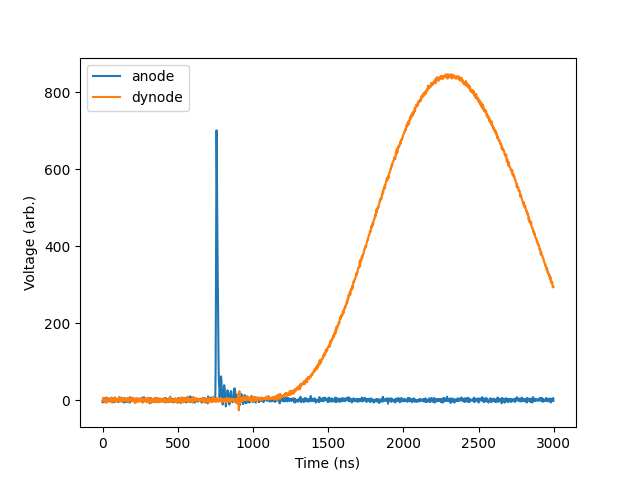

In [3]:
anode_trace = ev[0].get_trace()
dynode_trace = ev[1].get_trace()

time = np.arange(len(anode_trace))*2

plt.figure(0)

plt.plot(time, anode_trace, label='anode')
plt.plot(time, dynode_trace, label='dynode')
plt.xlabel('Time (ns)')
plt.ylabel('Voltage (arb.)')
plt.legend()

plt.show()

There is more that can be done in terms of manipulating the `event` object, but there shouldn't be a need for that, at least not at the current moment. For now we move on to the next method.

## `lst_out`
```Python
lst_out(events, ch, output, traces, cuts, inc, filename, align_method_lst_out, align_args_lst_out, integrals)
```

This method can be used to process a number of events and save some details to file. It has scope to consider cuts on the data but we will only discuss that at the end.

| Parameter | Type  | Details | Default |
|---    |---    |---    |---    |
| `events`  | int or `False`   | The number of events to read in. If `False`, the full file is read.| `False` |
| `ch`  | array int or `True` | If `True` all channels are read out. If int array, only the selected channels are read out (channel numbering from 0) | `True`    |
| `output`  | array int or bool | If `True` L, S, T_trigger [us], baseline [bits], pulse height [bits] are read out into a file per channel. If a binary int array (len=5) only the selected parameters are read out. The format of the array is [[L, S, T, baseline, PH]] where 1 is an indication to output that parameter and 0 is to ignore that parameter. It requires a unique array for each channel being processed, even when there's only one channel  | `True`    |
| `traces`  | bool  | If `True`, traces will be output in list mode in a csv file per channel. Otherwise traces will not be output  | `False`   |
| `cuts`    | array int or bool | If `False`, no cuts are applied to output. If an int array, it acts just like the cuts argument for `select_events`. If `True` it defaults to no cuts  | `False`   |
| `inc` | array int or `None` | Array of `1` or `-1` to indicate which cuts include or exclude events. Requires `len(inc) = len(cuts)`. If `None`, defaults to including all cuts. If `len(inc) != len(cuts)`, throws an error and `lst_out` returns None   | `None`    |
| `filename`    | str   | Desired output file name. If left empty, it uses the `file_name` of the original file    | ""    |
| `align_method_lst_out`  | str   | String denoting which method to use to find t_0. Can be 'CFD' or 'max' | `None`   |
| `align_args_lst_out`  | array float   | Array of arguments to be supplied to the alignment method function | `None`   |
| `integrals`  | array float   | Array of integral lengths in ns. [`start`, `short`, `long`] | `None`   |

This method outputs optional csv files containing data from each event, in list mode. Files will be named [*filename*]\_params\_[*ch*].csv and [*filename*]\_trace\_[*ch*].csv. Each channel will have its own pair of files.

Below we run it on the anode pulse for the first 100 events, getting traces out as well as the default parameters. Have a look at the newly created files in this directory. They should be named `STNG_params_0.csv` and `STNG_trace_0.csv`.

In [4]:
file.lst_out(100, [0], traces=True)

End reading


The `lst_out` method has some quirks (don't we all?) but they are manageable. One very important thing to note is that when using the `output` argument in its array form, an output format must be supplied for each channel, even if there is only 1 being output:

```Python
file.lst_out(100, [0], output=[[1,1,0,0,0]], etc...)
```

This is fairly common throughout this package so it's something to look out for if things aren't working. Those arguments that have a default of `None` will default to the values supplied to the `read_dat` initialisation for the same functionality. 

## `get_fails`
```Python
get_fails(display)
```

This takes one argument, `display`, which when `False` means it won't display anything to terminal. Default is `False`.

It returns an `nx5` array of ints, for `n` channels, in the format of [start, long, short, integral, zero]. The value at the associated index indicates the number of fails out of the processed events that have failed that check.

| Index | Fail Name | Fail Condition    |
|---    |---    |---    |
| 0 | start | The start time is set outside of the acquisition window   |
| 1 | long  | The long integral end gate is outside of the acquisition window   |
| 2 | short | The short integral end gate is outside of the acquisition window  |
| 3 | integral  | The calculated short integral is negative or the calculated long integral has a smaller value than the calculated short integral  |
| 4 | zero  | The CFD calculation failed to return a reasonable t_0  |

It also returns an array of `n` ints, saying how many fails per channel. Finally an event counter, for how many events were processed. See below that there were 101 events on each channel (unless you ran either `read_event` or `lst_out` many times), and some fails on channel 1.

In [5]:
fails = file.get_fails(display=True)
print(fails)

Channel: 0	Events: 101	Fails: 0.0
tstart: 0.0	tlong: 0.0	tshort: 0.0	integral: 0.0	t0: 0.0
Channel: 1	Events: 101	Fails: 23.0
tstart: 3.0	tlong: 0.0	tshort: 0.0	integral: 20.0	t0: 0.0
(array([[ 0.,  0.,  0.,  0.,  0.],
       [ 3.,  0.,  0., 20.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]]), array([ 0., 23.,  0.,  0.,  0.,  0.,  0.,  0.]), 101)


## `add_selections`
```Python
add_selections(x_param, y_param, x_param_name, y_param_name, mode, lims, file)
```

Method to add multiple cuts to the events. Can be run in manual `m` or predetermined `p` modes. 

| Parameter | Type | Details | Default |
|---    |---    |---    |---    |
| `x_param`   | array float   | Array of `x_param` values for the processed events  | []    |
| `y_param`   | array float   | Array of `y_param` values for the processed events  | []    |
| `x_param_name`   | str   | Name for the value provided to x_param, used for display only  | `'L'` |
| `y_param_name`   | str   | Name for the value provided to x_param, used for display only  | `'S'` |
| `mode`    | char  | `'m'`: Manual mode, `'p'`: predetermined mode | `'m'`   |
| `lims`    | 2x2 array float   | Array of x and y limits for the visual aid 2d histogram. The default value is specified in terms of channels and gets automatically calibrated using `calibration_m` and `calibration_c`    | [[0, 50000], [0, 1]]  |
| `file`    | `False` or str    | See explanation below | `False`   |

There are two modes of operation: manual `m` and predetermined `p`. 

Manual mode allows the user to input arrays of `x_param` and `y_param` values so that cuts can be made to separate, for example, the neutron and gamma events. These are usually `L` and `S`, so the default names are set to that, but they can be any two parameters that we want to use for PSD. The cut is made by clicking on points on a 2D histogram, defining a polygon that encloses the events of interest. In manual mode, these arrays of events **need** to be supplied or else it won't work. Once the cuts have been made, they get saved to the `read_dat` object and are used by the `select_events` method later on. 

By default, no file containing the coordinates of the selections is output when in manual mode. A key needs to be pressed (more on this later) and then they get output to a file named "`file_name`\_cuts.csv". That is the `file_name` that was used to instantiate the `read_dat` object and can't be made anything else from the program's side (I know this is weird but it's because of how we handle making cuts and that's too complicated for me to change just for this little quality of life improvement). The co-ordinates are saved in rows of cut_1_x, cut_1_y, cut_2_x, cut_2_y, etc... If the predetermined mode is being used, this step needs to happen first so that it has an input file to work with.

In predetermined mode, no arrays of `x_param` and `y_param` need to be supplied, and no display is shown for selections to be made. This mode simply takes the selections in the input file and loads them into the `read_dat` object. Here a `file` **needs** to be supplied.

### Making selections in manual mode

When in manual mode, we can make selections on the 2D histogram. There are a number of keys that can be pressed to activate certain commands.

| Key&nbsp;&nbsp; | Action    |
|---    |---    |
| a, A  | Start a new selection   |
| u, U  | Undo previous point, only usable while in a selection |
| x, X  | End current selection. Can only end a selection if there are more than 2 co-ordinates in the selection    |
| d, D  | Delete previous completed selection   |
| o, O  | Output the selections added to the file "`file_name`\_cuts.csv"  |
| q, Q  | Quit, ends visual guide and re-enters the main code segment   |

A typical selection would proceed as follows:
- Press "a" to start the selection.
- Choose at least 3 coordinates to enclose an area. If less than 3 are chosen before the next step, it will throw an error.
- Press "x" to end the selection. 
- If you want to export the selection so it can be used again later, press "o".
- Finally press "q" to quit.

One quirk of the system comes about if you use this method twice in manual mode in the same program. Once you've selected your region and want to output it to file, you can press "o" and it will do that, but the second time you do it and press "o", it will output all the selections made, including those made the first time you selected events. In some ways this is nice, so you won't overwrite old selections by accident, but it is something to be aware of.

In [6]:
L=[[],[]]
S=[[],[]]
for i in range(5000):#read 500 events
	event = file.read_event()
	for j in range(len(event)): #per channel
		S[j].append(event[j].get_pulse_shape())
		L[j].append(event[j].get_long_integral())

/home/mkidson/gitRepos/dDAQ_dev/dDAQ_final/event.py:116: RuntimeWarning: invalid value encountered in scalar divide
  return self.shortIntegral / self.longIntegral
/home/mkidson/gitRepos/dDAQ_dev/dDAQ_final/event.py:116: RuntimeWarning: divide by zero encountered in scalar divide
  return self.shortIntegral / self.longIntegral


In the cell above we simply imported 5000 events and saved their L and S values for analysis. We can now make some cuts on this data with the cell below. I've used `%matplotlib widget` in order to do the selection in the notebook. This may break as I'm not sure what the stability is like for that feature. If it doesn't work, change the "widget" to "tk" in the first cell of the notebook. This pops the plot out into a separate window, which is ugly but it works.

Make 3 cuts on the data; one for neutrons, one for gammas, and then a final one that selects only low energy neutrons, in that order. Press "o" and then "q" before continuing. See the image below to see what it should look like. `example_cuts.csv` contains the cuts seen here.

![](example_cuts.png)

In [7]:
# file.add_selections(L[0], S[0], mode="m")
file.add_selections(mode='p', file='example_cuts.csv') # Uncomment this to just use the pre-made cuts

Selections Imported
Polygons Created


# Warning

When making selections for cuts, try not to make things too complicated. This is not a hard and fast rule, but at most I would recommend putting two cuts on the same data, such as an inclusion cut and then a smaller exclusion cut. The functionality depends a fair bit on the order in which the cuts were made and if an exclusion cut is made before an inclusion cut, all hell breaks loose. I hope that I can fix this in the future but for now it will have to do.

---

## `select_events`

With the cuts made, we can start to actually separate events using this method. `add_selections` appends the cuts created to an internal variable of the `read_dat` class, which this method then accesses. 

```Python
select_events(x_param, y_param, x_param_name, y_param_name, cut_id, inc, visual, lims)
```
| Parameter | Type | Details | Default |
|---    |---    |---    |---    |
| `x_param`   | array float   | Array of `x_param` values for the processed events  | []    |
| `y_param`   | array float   | Array of `y_param` values for the processed events  | []    |
| `x_param_name`   | str   | Name for the value provided to x_param, used for display only  | `'L'` |
| `y_param_name`   | str   | Name for the value provided to x_param, used for display only  | `'S'` |
| `cut_id`  | array int | Array of cut ids which are either included or excluded. Cuts are in the order they were created.  | [0]   |
| `inc` | array int | Array of `1` or `-1` to indicate which cuts include or exclude events. Requires `len(inc) = len(cut_id)`   | [1]   |
| `visual`  | bool  | If `True` a 2D histogram with the included and excluded events is displayed with the cut boundaries. If `False` nothing is displayed  | `False`   |
| `lims`    | 2x2 array float   | Array of x and y limits for the visual aid 2D histogram. The default value is specified in terms of channels and gets automatically calibrated using `calibration_m` and `calibration_c`    | [[0, 50000], [0, 1]]  |


We can now make the cuts that we want. Note we have to provide the `L` and `S` arrays like before. These could of course be different arrays to those that were used in the selection process. First we want to just have the gamma events, so we use `cut_id=[1]` as the second cut that we made was for gammas. We also use `inc=[1]` to tell it to include everything inside that cut. 

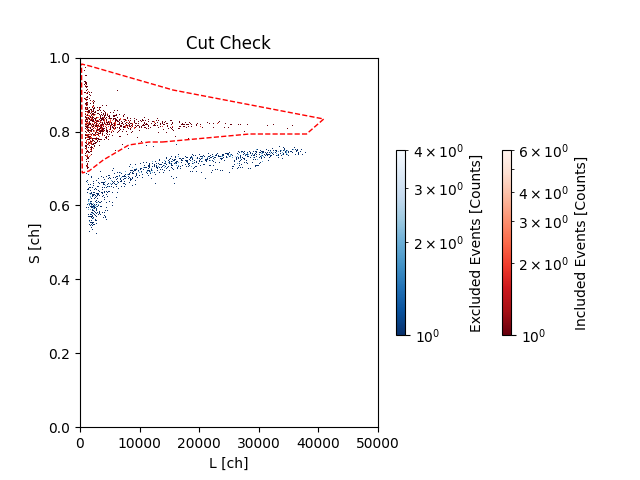

In [8]:
L_gammas, S_gammas = file.select_events(L[0], S[0], cut_id=[1], inc=[1], visual=True)

This should show the LS plot with a polygon drawn on it to indicate the cut. The included events are in the red colour scheme while the excluded events are in the blue. Below is an example of what it should look like.

<img src=gamma_cut.png>

We can then cut out neutrons, but here we are going to select only the high energy neutrons. We can do this because we made a cut around the low energy events. We use `cut_id=[0,2]` as those were the two cuts for the neutrons, as well as `inc=[1,-1]`. This includes everything in cut 0 but excludes everything in cut 2. 

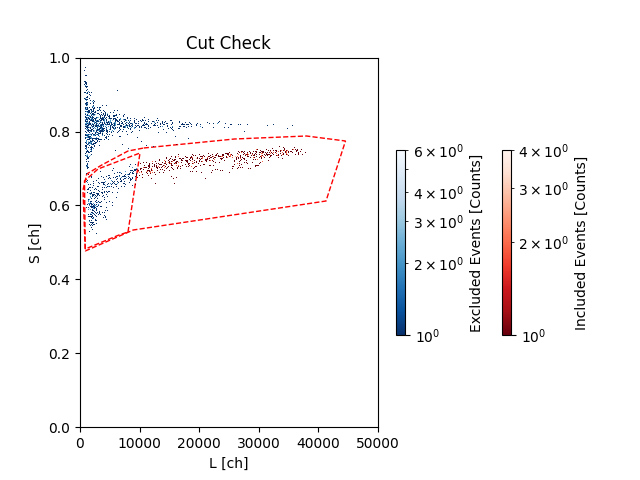

In [9]:
L_neutrons, S_neutrons = file.select_events(L[0], S[0], cut_id=[0,2], inc=[1,-1], visual=True)

We can see that only the events we wanted were included. If I'm honest I don't know how robust this system is so please for the love of god just keep things simple, unless you want to try improve it then we can chat.

<img src=neutron_double_cut.png>

The last thing we can do is use the cuts we made to get different `lst_out` output. This works in exactly the same way as `select_events`, where we have both a `cut` and `inc` argument. `lst_out` can of course be run with neither of these arguments supplied, but if they are supplied they work the same way. Below we apply the same cuts as we did when selecting high energy neutrons.

In [6]:
file.lst_out(100, [0], True, False, cuts=[0, 2], inc=[1, -1], filename='cut_lst_out.csv')

End reading


# My workflow

I've come to use certain workflows when using this package, and I thought it would be useful to explain them here. There may be an example notebook that follows this structure but at time of writing I have not done that yet.

Usually, I will initialise a file and immediately read in all of the events using `lst_out`, saving them to a csv. The only exception here is if I need to do some analysis to refine the choice of short and long integral lengths. With those event read in, I won't touch lst_out again, as it is fairly slow and saving just L and S values from each event is not too resource intensive (note here that I will usually use `lst_out` with the output argument being just `[[1,1,0,0,0]]`). 

At this point you can make a new program to do the rest, but I find it useful to stay in the same one, but just to comment out the `lst_out` line as we use the `read_dat` object again for the analysis.

I will then use `add_selections`, using the entire dataset to make my selections, and again usually only make one selection, namely a cut containing the neutron events. This is just preference and a cut containing gammas would probably suffice, but the method hinges on the fact that by excluding one type of event, I will only get the other type of event. This is not strictly true as there may be some weird outliers but I've found it works fairly well.

With selections made, I will then use `select_events` to select neutron and gamma events, but I usually don't save them to file as this processing takes very little time, so each time I want to redo analysis I will just run this all again. It saves space as you only need to have the csv of all L and S values on disk.

With those events imported, I can run my analysis however I like. I usually wait until this point to calibrate things, especially if I'm using an AmBe source, since we use the gamma events to calibrate so we need to separate everything before calibration anyway.